In [1]:
import sys
sys.path.append('/Users/Resource/Desktop/Optimization_Project/test')
import numpy as np
import pandas as pd
import Divvy_SA as sa
import Divvy_ACO as aco
from sklearn.externals import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
import pickle
from itertools import product
import xgboost
from grid_search import GridSearchOpt

from optimization_hyper_tune import optimization_hypterparameter_tuning

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
xgboost.__version__

'0.7.post4'

In [3]:
# ----------------- VARIABLE ----------------- #

path = '/Users/Resource/Desktop/Optimization_Project/test/'
output_path = '/Users/Resource/Desktop/Optimization_Project/test/'
sensor_file = '2018Q12_top25station_sensor.csv'
model_in_name = 'model_in.pkl'
model_out_name = 'model_out.pkl'
traffic_dataset_name = 'modeling_dataset.csv'
travel_distance_name = 'station_distances.csv'
station_info_name = "station_info.csv"

In [4]:
top_station_ids = [35, 192,  91,  77,  43, 133, 174,  81,  76,  90, 177, 287, 268,
                   195,  85, 283, 100,  66, 110,  52, 181,  48,  59, 176,  49]

sample_date = '2018-05-31'
sample_bin = 8 # start time(14:00-15:59) every 2 hour
features = ['month', 'dayofweek', 'time_bin',    # this has to be replaced later
            'in_trips_prev1', 'out_trips_prev1', 
            'in_trips_ystd', 'out_trips_ystd']

time_limit = 120
truck_capacity = 15
debug = False
start_station = 0

#sa_hyperparameters = {'temp_schedule': 100, 
#                  'K': 100, 
#                  'alpha': 0.96, 
#                  'iter_max': 1000, 
#                  'temp': 100, 
#                  'tolerance': 500
#                  }


sa_hyperparameters = {'temp_schedule': 80, 
                  'K': 50, 
                  'alpha': 0.8,
                  'iter_max': 5000, 
                  'temp': 100, 
                  'tolerance': 1000
                  }


aco_hyperparameters = {'n_ants': 1,
                      'n_best': 1,
                      'n_iterations': 500,
                      'decay': 0.5,
                      'alpha': 0.2,
                      'beta': 1}

# ---------------- Data Processiong Functions ---------------- #

In [5]:
def get_expected_cnt(net_flow, capacity, actual):
    # net inflow
    if net_flow > 0:
        return int(max(capacity - net_flow, 0))
    # net outflow
    elif net_flow < 0:
        return int(min(abs(net_flow), capacity))
    else:
        return int(actual)

def get_expected_cnt_extra(net_flow, capacity):
    # net inflow: (0, capacity - docks needed)
    if net_flow > 0:
        return (0, max(capacity - net_flow, 0))
    # net outflow: (bikes needed, full)
    elif net_flow < 0:
        return (min(abs(net_flow), capacity), capacity)
    # no adjustment needed
    else:
        return (0, capacity)

In [6]:
# ------------------ PREDICTION ------------------ #

# Load data & model
sensor_df = pd.read_csv(path + sensor_file)
model_inflow = joblib.load(path +  model_in_name)
model_outflow = joblib.load(path +  model_out_name)
traffic = pd.read_csv(path + traffic_dataset_name)
distance = pd.read_csv(path + "station_distances.csv", names = ["from", "to", "distance"])
station_info = pd.read_csv(path + station_info_name)

In [7]:
# Number of docks & station capacity
sensor_info = sensor_df[(sensor_df['date'] == sample_date) & (sensor_df['hour'] == sample_bin)
                        & (pd.to_datetime(sensor_df['date_clean']).dt.minute == 0)][['id', 'available_bikes', 'docks_in_service']]
sensor_info.columns = ['station_id', 'actual_cnt', 'capacity']

In [8]:
# Get distance matrix (min)
time_mtrx = distance[(distance['from'].isin(top_station_ids)) & (distance['to'].isin(top_station_ids))].copy()
time_mtrx = pd.pivot_table(time_mtrx, values='distance', index='from', columns='to', aggfunc=np.sum)
time_mtrx = time_mtrx / 600

In [9]:
# Get expected demand
case = traffic[(traffic['date'] == sample_date) & (traffic['time_bin'] == sample_bin)].copy()
case['inflow_pred'] = model_inflow.predict(case[features]).round()
case['outflow_pred'] = model_outflow.predict(case[features]).round()
case['net_flow'] = case['inflow_pred'] - case['outflow_pred']
case = pd.merge(case, sensor_info, on = 'station_id', how = 'outer')
case['expected_cnt'] = case[['net_flow', 'capacity', 'actual_cnt']].apply(lambda x: get_expected_cnt(x[0], x[1], x[2]), axis = 1)
case.sort_values('station_id', inplace = True)

In [10]:
# ------------------ RUN ACO ----------------- #

# Helper functions
def convert_ACO_time_mtrx(mtrx):
    N = len(mtrx)
    for i in range(N):
        mtrx[i][i] = np.inf
    return mtrx

In [11]:
# Get expected demand sample

# sample date & sample bins
def sample_20(sample_date, sample_bin):
    sensor_info = sensor_df[(sensor_df['date'] == sample_date) & (sensor_df['hour'] == sample_bin)
                            & (pd.to_datetime(sensor_df['date_clean']).dt.minute == 0)][['id', 'available_bikes', 'docks_in_service']]
    sensor_info.columns = ['station_id', 'actual_cnt', 'capacity']
    case = traffic[(traffic['date'] == sample_date) & (traffic['time_bin'] == sample_bin)].copy()
    case['inflow_pred'] = model_inflow.predict(case[features]).round()
    case['outflow_pred'] = model_outflow.predict(case[features]).round()
    case['net_flow'] = case['inflow_pred'] - case['outflow_pred']
    case = pd.merge(case, sensor_info, on = 'station_id', how = 'outer')
    case['expected_cnt'] = case[['net_flow', 'capacity', 'actual_cnt']].apply(lambda x: get_expected_cnt(x[0], x[1], x[2]), axis = 1)
    case.sort_values('station_id', inplace = True)
    return list(case['actual_cnt']), list(case['expected_cnt']), list(case['capacity'])


In [12]:
def iterate_sample_20(inpt):
    actual_lst = []
    expect_lst = []
    capacity_lst =[]
    for (i,j) in inpt:
        actual, expect, capacity = sample_20(i,j)
        actual_lst.append(actual)
        expect_lst.append(expect)
        capacity_lst.append(capacity)
    return actual_lst, expect_lst, capacity_lst

In [13]:
inpt1 = [('2018-05-31',6), ('2018-05-31',8), ('2018-05-31',10),('2018-05-21',8),('2018-05-31',12)]
inpt4 = [('2018-05-28',6), ('2018-05-28',8), ('2018-05-17',8),('2018-05-27',14),('2018-05-24',6)]

In [ ]:
inpt2 = [('2018-05-30',6), ('2018-05-30',8), ('2018-05-30',10),('2018-05-20',8),('2018-05-30',12)]
inpt3 = [('2018-05-29',6), ('2018-05-29',8), ('2018-05-29',10),('2018-05-19',8),('2018-05-29',12)]

In [14]:
inpt=[]
inpt.extend(inpt1)
inpt.extend(inpt4)

In [15]:
actual_lst, expect_lst,capacity_lst = iterate_sample_20(inpt)

In [16]:
aco_param = {"travel_time": convert_ACO_time_mtrx(time_mtrx.values),
                 "capacity" : truck_capacity, 
                 "time_constraint" : time_limit,
                 "start_station": start_station,
                 'n_ants':1,
                 'n_best':1,
                  'beta': 1,
                  'decay':1,
                  "n_iterations":100}

In [17]:
aco_hyper = {
          'alpha':[0.6,0.7,0.9],
          'decay':[0.8,0.9,1],
          "n_iterations":[100,200,500]
         }

In [20]:
sa_param = {"time_mtrx" : time_mtrx.values,
             "time_limit" : time_limit,
             "station_capacity" : capacity_lst[0],
             "truck_capacity" : truck_capacity,
             "debug" : debug,
             "do_nothing_punishment" : 0,
             }

In [21]:
sa_hyper = {'temp_schedule': [70,80,90], 
              'K': [50,60], 
              'alpha': [0.8,0.9],
              'iter_max': [100,500], 
              'temp': [90,100], 
              'tolerance': [1000,2000]
              }

In [22]:
#actual_lst = [list(case['actual_cnt'])]
#expect_lst = [list(case['expected_cnt'])]
from copy import deepcopy 

In [23]:
aco = optimization_hypterparameter_tuning(aco_param, aco_hyper, "aco", expect_lst, actual_lst)

In [26]:
df_aco_report = aco.report

In [27]:
aco.return_best()

         alpha  decay  n_iterations    satisfy  satisfiable_demand  \
case                                                                 
5     0.733333    0.9    266.666667   14.00000                14.0   
8     0.733333    0.9    266.666667   74.00000                74.0   
9     0.733333    0.9    266.666667   64.00000                64.0   
1     0.733333    0.9    266.666667  209.62963               226.0   
6     0.733333    0.9    266.666667   62.00000                72.0   

      satisfy/satisfiable  
case                       
5                1.000000  
8                1.000000  
9                1.000000  
1                0.927565  
6                0.861111  


In [28]:
aco.report.head()

,alpha,decay,n_iterations,satisfy,case,satisfiable_demand,satisfy/satisfiable
0,0.6,0.8,100,70,0,84,0.833333
1,0.6,0.8,200,70,0,84,0.833333
2,0.6,0.8,500,70,0,84,0.833333
3,0.6,0.9,100,70,0,84,0.833333
4,0.6,0.9,200,70,0,84,0.833333


In [ ]:
aco_hyper = {'n_ants':[1,2],
             'n_best':[1,2],
          'alpha':[0.6,0.7,0.9],
          'decay':[0.8,0.9,1],
          "n_iterations":[100,200,500]
         }

AxesSubplot(0.125,0.125;0.775x0.755)


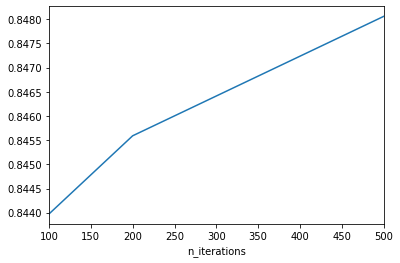

In [31]:
aco.compare_own_trend("n_iterations")

AxesSubplot(0.125,0.125;0.775x0.755)


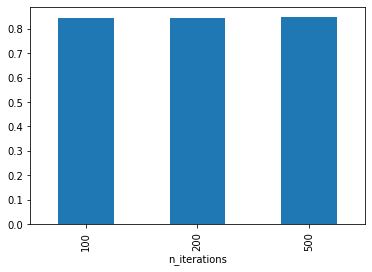

In [30]:
aco.compare_own_trend("n_iterations",'bar')

In [218]:
#s_a = optimization_hypterparameter_tuning(sa_param, sa_hyper, "sa", [expect_lst[i]], [actual_lst[i]], [capacity_lst[i]])

In [222]:
s_a = optimization_hypterparameter_tuning(sa_param, sa_hyper, "sa", expect_lst, actual_lst, capacity_lst)

In [226]:
s_a.return_best()

         temp_schedule     K  alpha  iter_max  temp  tolerance  case
satisfy                                                             
417                580   380    5.9       700   640      12000    35
413                 90    60    0.8       100   100       2000     5
412                390   270    4.2       500   480       5000    33
410                 90    60    0.8       100    90       2000     9
407               1780  1260   19.4      3900  2180      33000   115


In [227]:
s_a.report.columns

Index(['temp_schedule', 'K', 'alpha', 'iter_max', 'temp', 'tolerance',
       'satisfy', 'case'],
      dtype='object')

In [229]:
s_a.report.groupby(by=['temp_schedule', 'K', 'alpha', 'iter_max', 'temp', 'tolerance']).sum().sort_values(by='satisfy', ascending = False).head(5)

satisfy  case
temp_schedule K  alpha iter_max temp tolerance               
70            50 0.8   100      100  2000          2962    45
                 0.9   100      90   2000          2943    45
              60 0.9   100      100  1000          2923    45
                 0.8   100      90   1000          2910    45
80            60 0.9   100      90   2000          2910    45

In [149]:
# Sample larger than population or is negative
# Expected # bikes at stations exceeds capacity.
# Actual # bikes at stations exceeds capacity.
